In [1]:
import warnings
warnings.filterwarnings('ignore')

import transformers
import pandas as pd
import psaw
from plotnine import *

In [2]:
api = psaw.PushshiftAPI()

### Download all comments containing the phrase 'Scott Drew' in r/CollegeBasketball

In [3]:
gen = api.search_comments(q='"scott drew"', subreddit='CollegeBasketball')

max_response = 1000000

comment_list = []

for c in gen:
    comment_list.append(c)
    
    if len(comment_list) % 1000 == 0:
        print(len(comment_list))
    
    if len(comment_list) >  max_response:
        break
    

1000
2000


## Parse the list of comments to store them in a form more usable by pandas

In [4]:
comment_dict = {'flair': [], 'time': [], 'is_game_thread': [], 
                'score': [], 'link': [], 'text': []}

for comment in comment_list:
    flair = 'None'
    if comment.author_flair_css_class is not None:
        flair = comment.author_flair_css_class.lower()
        
        if flair == 'iowast':
            flair = 'iowastate'

    time = comment.created_utc
    score = comment.score

    if not hasattr(comment, 'permalink'):
        comment_dict['is_game_thread'].append(None)
        comment_dict['link'].append(None)
    else:
        if 'game_thread' in comment.permalink:
            comment_dict['is_game_thread'].append(True)
        else:
            comment_dict['is_game_thread'].append(False)
        comment_dict['link'].append(comment.permalink)

    comment_dict['flair'].append(flair)
    comment_dict['time'].append(time)
    comment_dict['score'].append(score)
    comment_dict['text'].append(comment.body)

# Remove numbers from alt flairs
for i in range(len(comment_dict['flair'])):
    comment_dict['flair'][i] = comment_dict['flair'][i].rstrip('0123456789')
    
comment_df = pd.DataFrame.from_dict(comment_dict)

In [5]:
# Convert seconds since 1970 to something readable
comment_df['time'] = pd.to_datetime(comment_df['time'], unit='s')

In [6]:
comment_df.head()

,flair,time,is_game_thread,score,link,text
0,gonzaga,2021-04-06 17:55:32,False,1,/r/CollegeBasketball/comments/mlgzky/now_that_...,In no particular order:\n\n1. K\n2. Jay Wright...
1,cincinnati,2021-04-06 17:29:56,False,1,/r/CollegeBasketball/comments/mlgw8l/should_th...,"Mark Few vs Scott Drew, no rules cagematch Sat..."
2,auburn,2021-04-06 16:09:02,True,1,/r/CollegeBasketball/comments/ml2h57/post_game...,"Seeing Timme and Watson guarding Butler, Mitch..."
3,texas,2021-04-06 15:45:58,False,1,/r/CollegeBasketball/comments/ml9fvz/opinion_b...,It was pretty stupid to not think he’s a good ...
4,kansas,2021-04-06 15:03:36,False,1,/r/CollegeBasketball/comments/mldltu/weekly_po...,lmao scott drew has as many titles as bill self


## Run sentiment analysis

In [7]:
# Load a pretrained sentiment-analysis transformer from hugging-face
analyzer = transformers.pipeline("sentiment-analysis")

In [8]:
example = "lmao scott drew has as many titles as bill self"
analyzer(example)

[{'label': 'NEGATIVE', 'score': 0.914427638053894}]

In [9]:
example = "Hot take, Scott Drew has an amazing recruiting"
analyzer(example)

[{'label': 'POSITIVE', 'score': 0.9998359084129333}]

In [10]:
def get_sentiment(row):
    return analyzer(row['text'])[0]['label']

def get_sentiment_score(row):
    return analyzer(row['text'])[0]['score']

In [11]:
# Shorten comments to their first 500 characters to fit into the transformer
comment_df['text'] = comment_df['text'].apply(lambda x: x[0:500])

In [12]:
comment_df['sentiment'] = comment_df.apply(get_sentiment, axis=1)
comment_df['sentiment_score'] = comment_df.apply(get_sentiment_score, axis=1)

comment_df.head()

,flair,time,is_game_thread,score,link,text,sentiment,sentiment_score
0,gonzaga,2021-04-06 17:55:32,False,1,/r/CollegeBasketball/comments/mlgzky/now_that_...,In no particular order:\n\n1. K\n2. Jay Wright...,NEGATIVE,0.579218
1,cincinnati,2021-04-06 17:29:56,False,1,/r/CollegeBasketball/comments/mlgw8l/should_th...,"Mark Few vs Scott Drew, no rules cagematch Sat...",NEGATIVE,0.634891
2,auburn,2021-04-06 16:09:02,True,1,/r/CollegeBasketball/comments/ml2h57/post_game...,"Seeing Timme and Watson guarding Butler, Mitch...",POSITIVE,0.983041
3,texas,2021-04-06 15:45:58,False,1,/r/CollegeBasketball/comments/ml9fvz/opinion_b...,It was pretty stupid to not think he’s a good ...,NEGATIVE,0.998341
4,kansas,2021-04-06 15:03:36,False,1,/r/CollegeBasketball/comments/mldltu/weekly_po...,lmao scott drew has as many titles as bill self,NEGATIVE,0.914428


<AxesSubplot:ylabel='Frequency'>

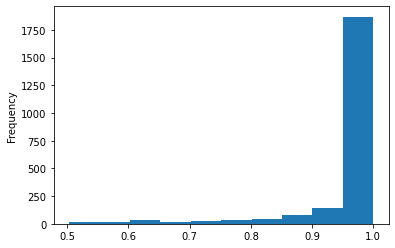

In [13]:
comment_df['sentiment_score'].plot.hist()

In [14]:
# Filter out posts the model is unsure about
sentiment_df = comment_df[comment_df['sentiment_score'] >= .9]

## Create visualizations

### Frequency of Scott Drew mentions over time

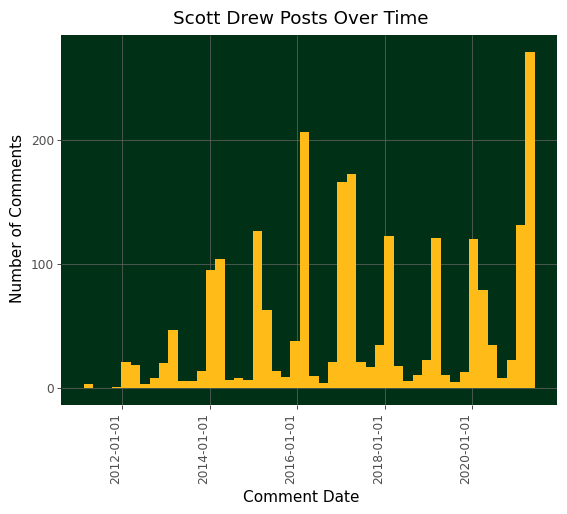

<ggplot: (8777493090262)>

In [15]:
(ggplot(comment_df, aes(x='time')) + 
    geom_histogram(fill= '#FFBC19', bins=48) + 
    ggtitle('Scott Drew Posts Over Time') +
    ylab('Number of Comments') +
    xlab('Comment Date') +
    theme_dark() +
    theme(axis_text_x=element_text(rotation=90, hjust=1),
          panel_grid_minor=element_blank(),
          panel_background=element_rect(fill='#003015', color='None')))

## Sentiment of Scott Drew mentions over time

In [16]:
sentiment_df['year'] = sentiment_df.time.dt.year

In [17]:
# The text field won't be empty so we can count the number of texts to get the number
# of posts with each sentiment in each year
sentiment_counts = sentiment_df.groupby(['year', 'sentiment'])['text'].count()
sentiment_counts = sentiment_counts.reset_index()
sentiment_counts.head()

,year,sentiment,text
0,2011,NEGATIVE,1
1,2011,POSITIVE,3
2,2012,NEGATIVE,44
3,2012,POSITIVE,11
4,2013,NEGATIVE,47


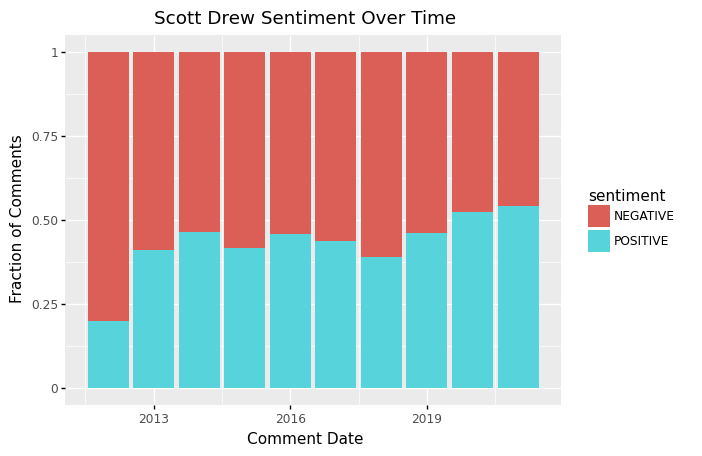

<ggplot: (8777493029133)>

In [18]:
# Skip 2011 since there were only 4 posts
(ggplot(sentiment_df[sentiment_df['year'] > 2011], aes(x='year', fill='sentiment')) + 
    geom_bar(position='fill', stat='count') + 
    ggtitle('Scott Drew Sentiment Over Time') +
    ylab('Fraction of Comments') +
    xlab('Comment Date'))

### Which team's fans talk about Scott Drew the most?
This isn't adjusted for number of fans, ideally this would be normalized into a metric like "scott drew mentions per thousand posts" or "millidrews" for short

In [19]:
comment_df['flair'].value_counts().to_frame().head(10)

,flair
kansas,700
baylor,365
iowastate,193
None,169
indiana,35
duke,33
kansasstate,33
kentucky,29
westvirginia,29
texastech,27
